# Fine-Tuning the CLIP Model

Or how we teach to the model what an "rhteddy" actually looks like. 

For reference, we want to generate a dog like this:

![redhat dog](https://rhods-public.s3.amazonaws.com/sample-data/images/redhat-dog-small.jpg)

## Install Requirements

In [25]:
!pip install -U pip
!pip install -r requirements_training.txt

  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-gtq1ql8k
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-gtq1ql8k
  Resolved https://github.com/huggingface/diffusers to commit a216b0bb7fbf713e348edb030e865c2703965bd2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 157.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 167.2 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.111
    Uninstalling botocore-1.34.111:
      Successfully uninstalled botocore-1.34.111
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.10.1
    Uninstalling s3transfer-0.10.1:
      Successful

In [26]:
!pip list | grep -E "boto3|torch|diffusers|transformers|accelerate|xformers|bitsandbytes"

accelerate                0.31.0
bitsandbytes              0.43.1
boto3                     1.26.165
codeflare-torchx          0.6.0.dev2
diffusers                 0.30.0.dev0
torch                     2.2.2+cu121
torchvision               0.17.2+cu121
transformers              4.42.2
xformers                  0.0.25.post1


## Library Import

Now we load all required libraries to be used in the training code

In [27]:
import os, random, yaml, threading
from datetime import datetime
try:
    import boto3
    from boto3.s3.transfer import TransferConfig
    from botocore.exceptions import ClientError
    import torch
    import torch.cuda as tc
    from diffusers import DiffusionPipeline
except Exception as e:
    print(f"Caught Exception: {e}")

### Define custom code to interact with S3 and the rest of the infrastructure

In [70]:
# dictionary class that holds parameters
# load values from a yaml file
class Parameters(object):
    def __init__(self, data: dict):
        if type(data) != dict:
            raise TypeError(f"Parameters: expected 'dict', got {type(data)}.")
        else:
            self.data = data

        for k in self.data.keys():
            if type(self.data.get(k)) != dict:
                self.__setattr__(k, self.data.get(k))
            else:
                self.__setattr__(k, Parameters(self.data.get(k)))

# shamelessly stolen from aws docs :D
class ProgressPercentage(object):
    def __init__(self, filename):
        self._filename = filename
        self._size = float(os.path.getsize(filename))
        self._seen_so_far = 0
        self._lock = threading.Lock()

    def __call__(self, bytes_amount):
        # To simplify, assume this is hooked up to a single filename
        with self._lock:
            self._seen_so_far += bytes_amount
            percentage = (self._seen_so_far / self._size) * 100
            sys.stdout.write(
                "\r%s  %s / %s  (%.2f%%)" % (
                    self._filename, self._seen_so_far, self._size,
                    percentage))
            sys.stdout.flush()

# checks whether a file exists in a remote bucket
def check_exists(s3api, bucket, filename):
    rsp = s3api.list_objects_v2(Bucket=bucket, Prefix=filename)
    try:
        contents = rsp.get("Contents")
        files = [ obj.get("Key") for obj in contents ]
        if filename in files:
            return True
        else:
            return False
    except Exception as e:
        return False

In [71]:
# load parameters file and read values into a dictionary class
try:
    with open("parameters.yaml.local") as parms:
        config_parms = yaml.safe_load(parms)
    params = Parameters(config_parms)
except yaml.YAMLError as e:
    print(f"Error loading YAML file: {e}")
    exit()
except Exception as e:
    print(f"Caught exception: {e}")
    exit()

### Check GPU

**It's recommended that you shut down any other notebook kernels.**

This fine tuning process uses a lot of video memory.   Here, we'll check on how much we have available.

In [30]:
accelerator = "cpu"
print(f"Checking for the availability of a GPU...")
if tc.is_available():
    device_name = tc.get_device_name()
    device_capabilities = tc.get_device_capability()
    device_available_mem, device_total_mem = [x / 1024**3 for x in tc.mem_get_info()]
    print(f"A GPU is available! [{device_name} - {device_capabilities} - {device_available_mem}/{device_total_mem} GB VRAM]")
    accelerator = "cuda"

print(f"Using accelerator: {accelerator}")

Checking for the availability of a GPU...
A GPU is available! [Tesla V100-SXM2-16GB - (7, 0) - 12.1429443359375/15.7725830078125 GB VRAM]
Using accelerator: cuda


## Settings

Here we set up all the options for training.  Most are environment variables which will allow us to override values from pipelines and run this notebook with different setting such as the base model or number of training steps and learning rate.

In [31]:
# we'll use accelerate from the CLI (we call that from python kernel)
BASEPATH = os.environ.get("BASEPATH", params.training.basePath)
MODEL_NAME = os.environ.get("MODEL_NAME", params.training.model_name)
OUTPUT_DIR = os.path.join(os.getcwd(), params.training.output_dir)
DATA_DIR = os.path.join(os.getcwd(), params.training.data_dir)
TRAINING_DATA_URL = os.environ.get("TRAINING_DATA_URL", params.training.training_data_url)
TRAINING_DIR = os.path.join(DATA_DIR, params.training.training_dir)
CLASS_DIR = os.path.join(DATA_DIR, params.training.class_dir)
TRAINING_PROMPT = os.environ.get("TRAINING_PROMPT", params.training.training_prompt)
CLASS_PROMPT = os.environ.get("CLASS_PROMPT", params.training.class_prompt)

# training steps, how long we fine tune the model
NUM_CLASS_IMAGES = int(os.environ.get("NUM_CLASS_IMAGES", params.training.num_class_images))
MAX_TRAIN_STEPS = int(os.environ.get("MAX_TRAIN_STEPS", params.training.max_train_steps))

# create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(TRAINING_DIR, exist_ok=True)

# display some info before launching the training job
print(f"Weights will be saved at {OUTPUT_DIR}")
print(f"It will be based on the model {MODEL_NAME}")
print(f"Training data located in downloaded from {TRAINING_DATA_URL}")
print(f"We're going to train the difference between \"{TRAINING_PROMPT}\" and \"{CLASS_PROMPT}\"")

Weights will be saved at /opt/app-root/src/text-to-image-demo/notebooks/notebook-output/stable_diffusion_weights/redhat-dog
It will be based on the model stabilityai/stable-diffusion-2-1
Training data located in downloaded from https://rhods-public.s3.amazonaws.com/sample-data/images/redhat-dog.tar.gz
We're going to train the difference between "photo of a rhteddy dog" and "a photo of dog"


## Fine Tuning The Model

### Get Training Data

We download some custom pictures of "rhteddy" from the Internet

In [32]:
import sys
import os
import tarfile
import urllib

url = TRAINING_DATA_URL
output = f"instance-images.tar.gz"
try: 
    urllib.request.urlretrieve(url, output)
    !tar -xzf instance-images.tar.gz -C $TRAINING_DIR
except Exception as e:
    print(f"Caught Exception: {e}")

!ls -lrta $TRAINING_DIR

total 3252
-rw-r--r--. 1 1000840000 1000840000 189966 Jul 26  2023 photo_2023-05-02_10-36-05.jpg
-rw-r--r--. 1 1000840000 1000840000 210563 Jul 26  2023 photo_2023-05-02_10-36-01.jpg
-rw-r--r--. 1 1000840000 1000840000 188703 Jul 26  2023 photo_2023-05-02_10-35-57.jpg
-rw-r--r--. 1 1000840000 1000840000 185122 Jul 26  2023 photo_2023-05-02_10-35-53.jpg
-rw-r--r--. 1 1000840000 1000840000 194484 Jul 26  2023 photo_2023-05-02_10-35-49.jpg
-rw-r--r--. 1 1000840000 1000840000 184048 Jul 26  2023 photo_2023-05-02_10-35-38.jpg
-rw-r--r--. 1 1000840000 1000840000 215683 Jul 26  2023 photo_2023-02-17_14-31-58.jpg
-rw-r--r--. 1 1000840000 1000840000 177453 Jul 26  2023 photo_2023-02-17_14-31-55.jpg
-rw-r--r--. 1 1000840000 1000840000 193099 Jul 26  2023 photo_2023-02-17_14-31-42.jpg
-rw-r--r--. 1 1000840000 1000840000 257751 Jul 26  2023 photo_2023-02-17_14-31-37.jpg
-rw-r--r--. 1 1000840000 1000840000 234345 Jul 26  2023 photo_2023-02-17_14-31-35.jpg
-rw-r--r--. 1 1000840000 1000840000 261561 

### Set up the Training Job

We use the 'accelerate' python package to run our training script directly from python but leveraging any available GPU

In [9]:
# generate a job configuration
!accelerate config default

Configuration already exists at /opt/app-root/src/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


In [10]:
# download the training script from github
#TODO: rewrite that from scratch using jupyter
!wget -O train_dreambooth.py https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth.py

--2024-06-28 12:28:44--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58466 (57K) [text/plain]
Saving to: ‘train_dreambooth.py’

train_dreambooth.py 100%[===================>]  57.10K  --.-KB/s    in 0.001s  

2024-06-28 12:28:44 (54.4 MB/s) - ‘train_dreambooth.py’ saved [58466/58466]



### Start Training

Here we kick off the training job with our chosen settings.  This will take about 15 minutes depending on settings and hardware.

This step will update the weights in the original model and "learn" how to interpret the "rhteddy" token to generate an image of the RedHat Dog.

In [33]:
!echo "MODEL_NAME=$MODEL_NAME"
!echo "OUTPUT_DIR=$OUTPUT_DIR"
!echo "DATA_DIR=$DATA_DIR"
!echo "TRAINING_DIR=$TRAINING_DIR"
!echo "CLASS_DIR=$CLASS_DIR"
!echo "TRAINING_PROMPT=$TRAINING_PROMPT"
!echo "CLASS_PROMPT=$CLASS_PROMPT"
!echo "NUM_CLASS_IMAGES=$NUM_CLASS_IMAGES"
!echo "MAX_TRAIN_STEPS=$MAX_TRAIN_STEPS"

MODEL_NAME=stabilityai/stable-diffusion-2-1
OUTPUT_DIR=/opt/app-root/src/text-to-image-demo/notebooks/notebook-output/stable_diffusion_weights/redhat-dog
DATA_DIR=/opt/app-root/src/text-to-image-demo/notebooks/notebook-output/data
TRAINING_DIR=/opt/app-root/src/text-to-image-demo/notebooks/notebook-output/data/training_dir
CLASS_DIR=/opt/app-root/src/text-to-image-demo/notebooks/notebook-output/data/class_dir
TRAINING_PROMPT=photo of a rhteddy dog
CLASS_PROMPT=a photo of dog
NUM_CLASS_IMAGES=200
MAX_TRAIN_STEPS=800


In [12]:
# flush gpu cache
tc.empty_cache()

# start training
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$TRAINING_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="$TRAINING_PROMPT" \
  --class_prompt="$CLASS_PROMPT" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=2 --gradient_checkpointing \
  --use_8bit_adam \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=$NUM_CLASS_IMAGES \
  --max_train_steps=$MAX_TRAIN_STEPS \
  --enable_xformers_memory_efficient_attention

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
06/28/2024 12:29:00 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'thresholding', 'dynamic_thresholding_ratio', 'sample_max_value', 'clip_sample_range', 'variance_type', 'timestep_spacing', 'rescale_betas_zero_snr'} was not found in config. Values will be initialized to default values.
{'shift_factor', 'latents_std', 'use_post_quant_conv', 'force_upcast', 'scaling_factor', 'latents_mean', 'use_quant_conv'} was not found in config. Values will be initialized to default values.
{'encoder_hid_dim', 'resnet_out_scale_factor', 'time_embedding_dim', 'ti

### Examine the output

If everything went well, we should have generated model weights in the `$OUTPUT_DIR` including those for the tokenizer, vae, unet, and text encoder.

- VAE: Variational Autoencoder, portion of the pipeline that transforms a tensor with latent data back into an image
- Tokenizer & text encoder: portions of the model that are in charge of transforming the input prompts in embeddings that are useful for the model to produce features we want in an image
- U-Net: Neural network that is in charge of the "denoising" part of stable diffusion. It takes a random noise latent tensor and information coming from the prompt/text encoder and produces a latent vector with the denoised information (e.g. features that we want in the resulting image)

These updated weights can be used as is (locally) to instantiate a Stable Diffusion pipeline and generate images with the added knowledge on how to create an RHTeddy image.

Let's try this by modifying the Stable Diffusion Pipeline code and perform an Inference on the updated model weights.

In [13]:
# show the updated model weights
!ls $OUTPUT_DIR

checkpoint-500	   logs		     scheduler	   tokenizer  vae
feature_extractor  model_index.json  text_encoder  unet


In [14]:
# load the model from local weights
pipeline = DiffusionPipeline.from_pretrained("notebook-output/stable_diffusion_weights/redhat-dog",
                                             torch_dtype = torch.float16)

# move the pipeline to the accelerator device
device = torch.device(accelerator)
pipeline.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.30.0.dev0",
  "_name_or_path": "notebook-output/stable_diffusion_weights/redhat-dog",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [15]:
# define prompts:
# this is the positive prompt, we declare what we want to get from the model
positive = "a photo of a rhteddy dog"
# this is the negative prompt. Strictly not mandatory, we can use this to
# specify things that we do *not* want in the final image
negative = "ugly, deformed, bad_anatomy"
# guidance scale
cfg = 3.5
# seed bit length
bit_length = 64
# generation steps
steps = 30
# image width & height
img_size = { 'w': 512, 'h': 512}

In [16]:
# generate a random seed for the torch generator
seed = random.getrandbits(bit_length)

# create a generator object with the custom seed value
torch_gen = torch.Generator(accelerator).manual_seed(seed)
print(f"Generating with seed: {torch_gen.seed()}")

# call the model via diffusers pipeline
gen_tensors = pipeline(prompt=positive,
                       negative_prompt=negative,
                       guidance_scale=cfg,
                       generator=torch_gen,
                       width=img_size.get('w'),
                       height=img_size.get('h'),
                       num_inference_steps=steps)

Generating with seed: 1863017999130391


  0%|          | 0/30 [00:00<?, ?it/s]

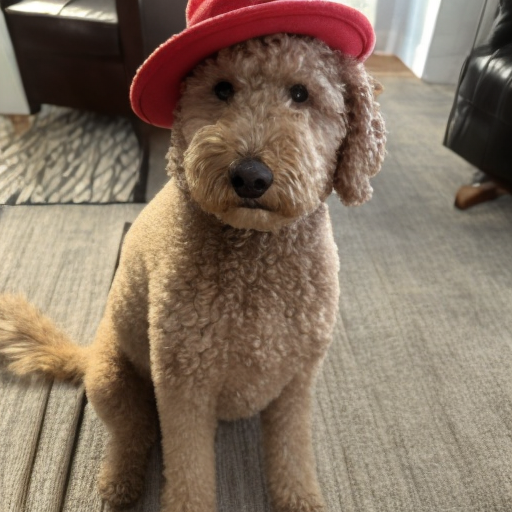

In [17]:
# extract the image
img = gen_tensors.images[0]

# display
img

### Note
The updated model is also ready for upload to a new dedicated Huggingface repository, where you can use those weights in another notebook or application.

To try out the custom weight from huggingface (or any other weights) with multiple images generated, try the notebook [misc-notebooks/generate_multiple.ipynb](misc-notebooks/generate_multiple.ipynb).

# Save the updated model to an S3 Bucket

Now we have our updated model working from the local filesystem, however, it's not doing much good in this notebook.
We need to push the model to our connected storage location. Then we can use it in another notebook or serve the models for use within an application.

Note: This requires a data connection to an S3 compatible bucket. As part of the setup you should have deployed an instance of MinIO from this [helm chart](https://github.com/mcaimi/minio-helm)


In [72]:
# connect to MinIO and prepare buckets
print(f"Accessing S3 endpoint {params.s3.url} with ACCESS_KEY {params.s3.accessKey}...")

# instantiate connection
minio_api = boto3.client("s3", endpoint_url=params.s3.url, region_name=params.s3.region, aws_access_key_id=params.s3.accessKey, aws_secret_access_key=params.s3.secretKey)

minio_api.list_buckets()
# Create the models bucket
available_buckets = [buckets["Name"] for buckets in minio_api.list_buckets()["Buckets"]]
for bckname in params.s3.bucket_list:
    print(f"-> Creating bucket {bckname}...")
    if bckname not in available_buckets:
        try:
            minio_api.create_bucket(Bucket=bckname)
        except Exception as e:
            print(f"Failure during bucket creation due to this error: {e}")
    else:
        print(f"--> Bucket ({bckname}) Already Exists. Skipping...")

Accessing S3 endpoint http://minio-svc.minio.svc.cluster.local:9000 with ACCESS_KEY BsWLcNhJGgbEYyYx08kh...
-> Creating bucket models...
--> Bucket (models) Already Exists. Skipping...
-> Creating bucket pipelines...
--> Bucket (pipelines) Already Exists. Skipping...
-> Creating bucket trainingdata...
--> Bucket (trainingdata) Already Exists. Skipping...


In [73]:
# Set the desired multipart threshold value (5GB)
GB = 1024 ** 3
transfer_config = TransferConfig(multipart_threshold = 5*GB, use_threads=True)

# get a list of all files to upload
remote_model_objects = dict()
for root, dirs, files in os.walk(OUTPUT_DIR):
    for filename in files:
        file_path = os.path.join(root, filename)
        relative_path = os.path.relpath(file_path, OUTPUT_DIR)
        s3_key = os.path.join(params.s3.prefix, relative_path)
        remote_model_objects[file_path] = s3_key

try:
    for k in remote_model_objects.keys():
        if not check_exists(minio_api, params.s3.modelBucket, remote_model_objects[k]):
            print(f"Uploading {remote_model_objects[k]} to MinIO bucket {params.s3.modelBucket}")
            minio_api.upload_file(k, params.s3.modelBucket,
                                    remote_model_objects[k],
                                    Callback=ProgressPercentage(k),
                                    Config=transfer_config)
            print("---")
        else:
            print(f"File {k} already exists in {params.s3.modelBucket}")
except ClientError as e:
    print(f"S3 Exception: {e.response['Error']['Code']}, trace: {e}")   
except Exception as e:
    print(f"Caught exception: {e}")

print("Upload Complete.")

File /opt/app-root/src/text-to-image-demo/notebooks/notebook-output/stable_diffusion_weights/redhat-dog/model_index.json already exists in models
File /opt/app-root/src/text-to-image-demo/notebooks/notebook-output/stable_diffusion_weights/redhat-dog/logs/dreambooth/events.out.tfevents.1719576951.sd-workbench-0.522.0 already exists in models
File /opt/app-root/src/text-to-image-demo/notebooks/notebook-output/stable_diffusion_weights/redhat-dog/logs/dreambooth/events.out.tfevents.1719577572.sd-workbench-0.825.0 already exists in models
File /opt/app-root/src/text-to-image-demo/notebooks/notebook-output/stable_diffusion_weights/redhat-dog/logs/dreambooth/events.out.tfevents.1719577769.sd-workbench-0.985.0 already exists in models
File /opt/app-root/src/text-to-image-demo/notebooks/notebook-output/stable_diffusion_weights/redhat-dog/logs/dreambooth/1719577769.1278918/events.out.tfevents.1719577769.sd-workbench-0.985.1 already exists in models
File /opt/app-root/src/text-to-image-demo/noteb